# CCS-AMP for unsourced multiple access

This notebook contains CCS-AMP encoder/decoder for unsourced multiple access using Hadamard design matrices.

The proposed algorithm goes back and forth between inner AMP and outer tree decoding components.

The code is based on the following articles:

A coded compressed sensing scheme for uncoordinated multiple access, available @ https://arxiv.org/pdf/1809.04745.pdf

SPARCs for Unsourced Random Access, available @ https://arxiv.org/abs/1901.06234

On Approximate Message Passing for Unsourced Access with Coded Compressed Sensing, available @ https://arxiv.org/pdf/2001.03705.pdf


In [13]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
# from pyfht import block_sub_fht

In [14]:
def fht(u):
    """
    Perform fast Hadamard transform of u, in-place.
    Note len(u) must be a power of two.
    """
    N = len(u)
    i = N>>1
    while i:
        for j in range(N):
            if (i&j) == 0:
                temp = u[j]
                u[j] += u[i|j]
                u[i|j] = temp - u[i|j]
        i>>= 1

def sub_fht(n, m, seed=0, ordering=None, new_embedding=False):
    """
    Returns functions to compute the sub-sampled Walsh-Hadamard transform,
    i.e., operating with a wide rectangular matrix of random +/-1 entries.

    n: number of rows
    m: number of columns

    It is most efficient (but not required) for max(m,n+1) to be a power of 2.

    seed: determines choice of random matrix
    ordering: optional n-long array of row indices in [1, max(m,n)] to
              implement subsampling; generated by seed if not specified,
              but may be given to speed up subsequent runs on the same matrix.

    Returns (Ax, Ay, ordering):
        Ax(x): computes A.x (of length n), with x having length m
        Ay(y): computes A'.y (of length m), with y having length n
        ordering: the ordering in use, which may have been generated from seed
    """
    assert n > 0, "n must be positive"
    assert m > 0, "m must be positive"
    if new_embedding:
        w = 2**int(np.ceil(np.log2(max(m+1, n+1))))
    else:
        w = 2**int(np.ceil(np.log2(max(m, n+1))))

    if ordering is not None:
        assert ordering.shape == (n,)
    else:
        rng = np.random.RandomState(seed)
        idxs = np.arange(1, w, dtype=np.uint32)
        rng.shuffle(idxs)
        ordering = idxs[:n]

    def Ax(x):
        assert x.size == m, "x must be m long"
        y = np.zeros(w)
        if new_embedding:
            y[w-m:] = x.reshape(m)
        else:
            y[:m] = x.reshape(m)
        fht(y)
        return y[ordering]

    def Ay(y):
        assert y.size == n, "input must be n long"
        x = np.zeros(w)
        x[ordering] = y.reshape(n)
        fht(x)
        if new_embedding:
            return x[w-m:]
        else:
            return x[:m]

    return Ax, Ay, ordering

def block_sub_fht(n, m, l, seed=0, ordering=None, new_embedding=False):
    """
    As `sub_fht`, but computes in `l` blocks of size `n` by `m`, potentially
    offering substantial speed improvements.

    n: number of rows
    m: number of columns per block
    l: number of blocks

    It is most efficient (though not required) when max(m,n+1) is a power of 2.

    seed: determines choice of random matrix
    ordering: optional (l, n) shaped array of row indices in [1, max(m, n)] to
              implement subsampling; generated by seed if not specified, but
              may be given to speed up subsequent runs on the same matrix.

    Returns (Ax, Ay, ordering):
        Ax(x): computes A.x (of length n), with x having length l*m
        Ay(y): computes A'.y (of length l*m), with y having length n
        ordering: the ordering in use, which may have been generated from seed
    """
    assert n > 0, "n must be positive"
    assert m > 0, "m must be positive"
    assert l > 0, "l must be positive"

    if ordering is not None:
        assert ordering.shape == (l, n)
    else:
        if new_embedding:
            w = 2**int(np.ceil(np.log2(max(m+1, n+1))))
        else:
            w = 2**int(np.ceil(np.log2(max(m, n+1))))
        rng = np.random.RandomState(seed)
        ordering = np.empty((l, n), dtype=np.uint32)
        idxs = np.arange(1, w, dtype=np.uint32)
        for ll in range(l):
            rng.shuffle(idxs)
            ordering[ll] = idxs[:n]

    def Ax(x):
        assert x.size == l*m
        out = np.zeros(n)
        for ll in range(l):
            ax, ay, _ = sub_fht(n, m, ordering=ordering[ll],
                                new_embedding=new_embedding)
            out += ax(x[ll*m:(ll+1)*m])
        return out

    def Ay(y):
        assert y.size == n
        out = np.empty(l*m)
        for ll in range(l):
            ax, ay, _ = sub_fht(n, m, ordering=ordering[ll],
                                new_embedding=new_embedding)
            out[ll*m:(ll+1)*m] = ay(y)
        return out

    return Ax, Ay, ordering


# Outer Tree encoder

This function encodes the payloads corresponding to users into codewords from the specified tree code. 

Parity bits in section $i$ are generated based on the information sections $i$ is connected to

Computations are done within the ring of integers modulo length of the section to enable FFT-based BP on the outer graph

This function outputs the sparse representation of encoded messages

In [15]:
def Tree_encode(tx_message,K,messageBlocks,G,L,J):
    encoded_tx_message = np.zeros((K,L),dtype=int)
    
    encoded_tx_message[:,0] = tx_message[:,0:J].dot(2**np.arange(J)[::-1])
    for i in range(1,L):
        if messageBlocks[i]:
            # copy the message if i is an information section
            encoded_tx_message[:,i] = tx_message[:,np.sum(messageBlocks[:i])*J:(np.sum(messageBlocks[:i])+1)*J].dot(2**np.arange(J)[::-1])
        else:
            # compute the parity if i is a parity section
            indices = np.where(G[i])[0]
            ParityInteger=np.zeros((K,1),dtype='int')
            for j in indices:
                ParityInteger1 = encoded_tx_message[:,j].reshape(-1,1)
                ParityInteger = np.mod(ParityInteger+ParityInteger1,2**J)
            encoded_tx_message[:,i] = ParityInteger.reshape(-1)
    
    return encoded_tx_message



This function converts message indices into $L$-sparse vectors of length $L 2^J$.

In [16]:
def convert_indices_to_sparse(encoded_tx_message_indices,L,J,K):
    encoded_tx_message_sparse=np.zeros((L*2**J,1),dtype=int)
    for i in range(L):
        A = encoded_tx_message_indices[:,i]
        B = A.reshape([-1,1])
        np.add.at(encoded_tx_message_sparse, i*2**J+B, 1)        
    return encoded_tx_message_sparse

This function returns the index representation corresponding to a SPARC-like vector.

In [17]:
def convert_sparse_to_indices(cs_decoded_tx_message_sparse,L,J,listSize):
    cs_decoded_tx_message = np.zeros((listSize,L),dtype=int)
    for i in range(L):
        A = cs_decoded_tx_message_sparse[i*2**J:(i+1)*2**J]
        idx = (A.reshape(2**J,)).argsort()[np.arange(2**J-listSize)]
        B = np.setdiff1d(np.arange(2**J),idx)
        cs_decoded_tx_message[:,i] = B 

    return cs_decoded_tx_message

Extract information bits from retained paths in the tree.

In [18]:
def extract_msg_indices(Paths,cs_decoded_tx_message, L,J):
    msg_bits = np.empty(shape=(0,0))
    L1 = Paths.shape[0]
    for i in range(L1):
        msg_bit=np.empty(shape=(0,0))
        path = Paths[i].reshape(1,-1)
        for j in range(path.shape[1]):
            msg_bit = np.hstack((msg_bit,cs_decoded_tx_message[path[0,j],j].reshape(1,-1))) if msg_bit.size else cs_decoded_tx_message[path[0,j],j]
            msg_bit=msg_bit.reshape(1,-1)
        msg_bits = np.vstack((msg_bits,msg_bit)) if msg_bits.size else msg_bit           
    return msg_bits


## SPARC Codebook

We use the `block_sub_fht` which computes the equivalent of $A.\beta$ by using $L$ separate $M\times M$ Hadamard matrices. However we want each entry to be divided by $\sqrt{n}$ to get the right variance, and we need to do a reshape on the output to get column vectors, so we'll wrap those operations here.

Returns two functions `Ab` and `Az` which compute $A\cdot B$ and $z^T\cdot A$ respectively.

In [19]:
def sparc_codebook(L, M, n,P):
    Ax, Ay, _ = block_sub_fht(n, M, L, ordering=None)
    def Ab(b):
        return Ax(b).reshape(-1, 1)/ np.sqrt(n)
    def Az(z):
        return Ay(z).reshape(-1, 1)/ np.sqrt(n) 
    return Ab, Az

# Vector Approximation

This function outputs the closest approximation to the input vector given that its L1 norm is 1 and no entry is greater than 1/K

In [20]:
def approximateVector(x, k):    

    # normalize initial value of x
    xOrig = x / np.linalg.norm(x, ord=1)
    
    # create vector to hold best approximation of x
    xHt = xOrig.copy()
    u = np.zeros(len(xHt))
    
    # run approximation algorithm
    while np.amax(xHt) > (1/k):
        for i in range(len(xHt)):
            xHt[i] = np.min([xHt[i], 1/k])
            u[i] = int((xHt[i] != 1/k))
        
        deficit = 1 - np.linalg.norm(xHt, ord=1)
        
        if deficit > 0:
            uxNorm = np.linalg.norm((xHt * u), ord=1)
            scaleFactor = (deficit + uxNorm) / uxNorm
            xHt = scaleFactor*(u*xHt) + (1/k)*(u == 0).astype(int)
            
    # return admissible approximation of x
    return xHt

# BP on outer graph

This function computes the priors on the unknown sparse vector, given effective obervations of the (graph) neighboring sections

In [21]:
def computePrior(s,G,messageBlocks,L,M,p0,K,τ,Phat,numBPiter,performApproximation):
    
    q = np.zeros(s.shape,dtype=float)
    p1 = p0*np.ones(s.shape,dtype=float)
    
    for iter in range(numBPiter):
        
        # Translate the effective observation into PME. For the first iteration of BP, use the uninformative prior p0
        temp_beta = (p1*np.exp(-(s-np.sqrt(Phat))**2/(2*τ**2)))/ (p1*np.exp(-(s-np.sqrt(Phat))**2/(2*τ**2)) + (1-p1)*np.exp(-s**2/(2*τ**2))).astype(float).reshape(-1, 1)

    
        # Reshape PME into an LxM matrix
        Beta = temp_beta.reshape(L,-1)
        #print(Beta.shape,np.sum(Beta,axis=1))
        Beta = Beta/(np.sum(Beta,axis=1).reshape(L,-1))
        # Rotate PME 180deg about y-axis
        Betaflipped = np.hstack((Beta[:,0].reshape(-1,1),np.flip(Beta[:,1:],axis=1)))
        # Compute and store all FFTs
        BetaFFT = np.fft.fft(Beta)
        BetaflippedFFT = np.fft.fft(Betaflipped)
        for i in range(L):
            if messageBlocks[i]:
                # Parity sections connected to info section i
                parityIndices = np.where(G[i])[0]
                BetaIFFTprime = np.empty((0,0)).astype(float)
                for j in parityIndices:
                    # Other info blocks connected to this parity block
                    messageIndices = np.setdiff1d(np.where(G[j])[0],i)
                    BetaFFTprime = np.vstack((BetaFFT[j],BetaflippedFFT[messageIndices,:]))
                    # Multiply the relevant FFTs
                    BetaFFTprime = np.prod(BetaFFTprime,axis=0)
                    # IFFT
                    BetaIFFTprime1 = np.fft.ifft(BetaFFTprime).real
                    BetaIFFTprime = np.vstack((BetaIFFTprime,BetaIFFTprime1)) if BetaIFFTprime.size else BetaIFFTprime1
                BetaIFFTprime = np.prod(BetaIFFTprime,axis=0)
            else:
                BetaIFFTprime = np.empty((0,0)).astype(float)
                # Information sections connected to this parity section (assuming no parity over parity sections)
                Indices = np.where(G[i])[0]
                # FFT
                BetaFFTprime = BetaFFT[Indices,:]
                # Multiply the relevant FFTs
                BetaFFTprime = np.prod(BetaFFTprime,axis=0)
                # IFFT
                BetaIFFTprime = np.fft.ifft(BetaFFTprime).real
            
            # Normalize to ensure it sums to one
            # p1[i*M:(i+1)*M] = (BetaIFFTprime/np.sum(BetaIFFTprime)).reshape(-1,1)            
            # p1[i*M:(i+1)*M]  = 1-(1-p1[i*M:(i+1)*M] )**K 
            if performApproximation: 
                # p1[i*M:(i+1)*M] = approximateVector(p1[i*M:(i+1)*M].ravel(), K).reshape((M, 1))
                p1[i*M:(i+1)*M] = approximateVector(BetaIFFTprime.ravel(), K).reshape((M, 1))
            else:
                p1[i*M:(i+1)*M] = (BetaIFFTprime/np.sum(BetaIFFTprime)).reshape(-1,1)            
                p1[i*M:(i+1)*M]  = 1-(1-p1[i*M:(i+1)*M] )**K 
                
            
    q = np.minimum(p1,1)          
    return q


## AMP
This is the actual AMP algorithm. It's a mostly straightforward transcription from the relevant equations, but note we use `longdouble` types because the expentials are often too big to fit into a normal `double`.

In [22]:
def amp(y, σ_n, P, L, M, T, Ab, Az,p0,K,G,messageBlocks,BPonOuterGraph,numBPiter,performApproximation):

    n = y.size
    β = np.zeros((L*M, 1))
    z = y
    Phat = n*P/L
    # Store the values of τ corresponding to each iteration
    τ_evolution = np.zeros((T,1))
    
    for t in range(T):
        
        # Compute τ online using the residual
        τ = np.sqrt(np.sum(z**2)/n)
        
        # effective observation
        s = (np.sqrt(Phat)*β + Az(z)).astype(np.longdouble)
        
        if BPonOuterGraph==0:
            # Use the uninformative prior p0 for Giuseppe's scheme
            q = p0
        else:
            # Compute the prior through BP on outer graph
            q = computePrior(s,G,messageBlocks,L,M,p0,K,τ,Phat,numBPiter,performApproximation)
            
        # denoiser
        β = (q*np.exp(-(s-np.sqrt(Phat))**2/(2*τ**2)))/ (q*np.exp(-(s-np.sqrt(Phat))**2/(2*τ**2)) + (1-q)*np.exp(-s**2/(2*τ**2))).astype(float).reshape(-1, 1)
        
        # residual
        z = y - np.sqrt(Phat)*Ab(β) + (z/(n*τ**2)) * (Phat*np.sum(β) - Phat*np.sum(β**2))
        τ_evolution[t] = τ

    return β,τ_evolution

# Simulation

In [51]:
K=4      # Number of active users (sparsity level of index vector)
B=32     # Payload size of each active user (number of bits each active device wants to transmit)
L=8      # Number of sections/sub-blocks
J=8      # Length of each coded sub-block
n=1536   # Total number of channel uses (real d.o.f) - used for appropriate power calculations (N = L*K*J*lambda=6)
T=6      # Number of AMP iterations
M=2**J   # Length of each section
messageBlocks = np.array([1,1,1,1,0,0,0,0]).astype(int) # Indicates the indices of information blocks
G = np.zeros((L,L)).astype(int) # Adjacency matrix of the outer code/graph
# G contains info on what parity blocks a message is attached to and what message blocks a parity is involved with
# Currently, we do not allow parity over parities. BP code needs to be modified a little to accomodate parity over parities
G[0, [4, 6]] = 1  # 0, 1, 2, 3 info
G[1, [5, 6]] = 1  # 4, 5, 6, 7 parity 
G[2, [4, 7]] = 1
G[3, [5, 7]] = 1
G[4, [0, 2]] = 1
G[5, [1, 3]] = 1
G[6, [0, 1]] = 1
G[7, [2, 3]] = 1

BPonOuterGraph = 1 # Indicates if BP is allowed on the outer code.Setting this to zero defaults back to Giuseppe's scheme that uses uninformative prior
numBPiter = 1; # Number of BP iterations on outer code. 1 seems to be good enough & AMP theory including state evolution valid only for one BP iteration
# EbNodB = 6.5 # Energy per bit. With iterative extension, operating EbN0 falls to 2.05 dB for 25 users with 1 round SIC

# function that runs simulation
def simulate(EbNodB, k, performApproximation):
    K = k
    listSize = 4*K       # List size retained for each section after AMP converges
    p0 = 1-(1-1/M)**K    # Giuseppe's uninformative prior
    delta = 0
    maxSims=10           # number of simulations
    
    # EbN0 in linear scale
    EbNo = 10**(EbNodB/10)
    P = 2*B*EbNo/n
    σ_n = 1
    
    # We assume equal power allocation for all the sections. Code has to be modified a little to accomodate non-uniform power allocations
    Phat = n*P/L

    # Variables used for computing Mean-Squared Error
    msgDetected=0
    mserrs = np.zeros(maxSims)

    for sims in range(maxSims):

        # Generate active users message sequences
        tx_message = np.random.randint(2, size=(K,B))

        # Outer-encode the message sequences
        encoded_tx_message_indices = Tree_encode(tx_message,K,messageBlocks,G,L,J)

        # Convert indices to sparse representation
        β_0 = convert_indices_to_sparse(encoded_tx_message_indices,L,J,K)

        # Generate the binned SPARC codebook
        Ab, Az = sparc_codebook(L, M, n, P)

        # Generate our transmitted signal X
        x = np.sqrt(Phat)*Ab(β_0)

        # Generate random channel noise and thus also received signal y
        z = np.random.randn(n, 1) * σ_n
        y = (x + z).reshape(-1, 1)

        # Run AMP decoding
        β, τ_evolution = amp(y, σ_n, P, L, M, T, Ab, Az,p0,K,G,messageBlocks,BPonOuterGraph,numBPiter,performApproximation)        
        
        # Compute Mean-squared error for current simulation
        mserrs[sims] = (1/(n*P)) * np.linalg.norm(β-β_0)**2;

    mse = sum(mserrs) / maxSims
    return mse

# MSE vs SNR

Running simulation 1/12
Running simulation 2/12
Running simulation 3/12
Running simulation 4/12
Running simulation 5/12
Running simulation 6/12
Running simulation 7/12
Running simulation 8/12
Running simulation 9/12
Running simulation 10/12
Running simulation 11/12
Running simulation 12/12
[[0.05195415 0.0079227  0.00377852 0.00202917 0.00148526 0.00064351]
 [0.06481903 0.01218495 0.0016188  0.00121794 0.00049103 0.00057532]]


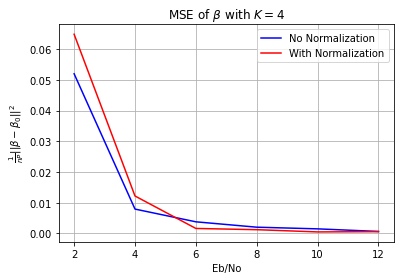

In [52]:
rangeSNR = np.array([2, 4, 6, 8, 10, 12])
data = np.zeros((2, len(rangeSNR)))
K = 4

for idxSim in range(2):
    for idxSnr in range(len(rangeSNR)):
        print(f'Running simulation {(idxSim)*(len(rangeSNR))+idxSnr+1}/{2*len(rangeSNR)}')
        data[idxSim, idxSnr] = simulate(rangeSNR[idxSnr], K, idxSim)
        
print(data)

# Plot results of MSE vs SNR
plt.figure(1)
plt.plot(rangeSNR, data[0,:], 'b', label='No Normalization')
plt.plot(rangeSNR, data[1, :], 'r', label='With Normalization')
plt.legend()
plt.xlabel('Eb/No')
plt.ylabel(r'$\frac{1}{nP}||\beta-\beta_{0}||^2$')
plt.title(r'MSE of $\beta$ with $K=4$')
plt.grid(True)

# MSE vs Sparsity Level (K)

Running simulation 1/6
Running simulation 2/6
Running simulation 3/6
Running simulation 4/6
Running simulation 5/6
Running simulation 6/6
[[0.0012274  0.00107218 0.00247247]
 [0.00074468 0.00049536 0.00682597]]


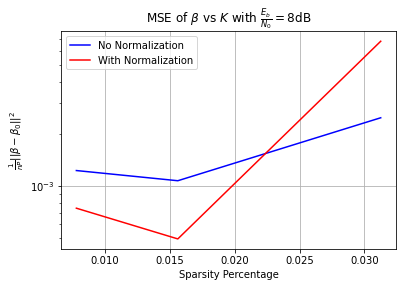

In [65]:
sparsityParams = np.array([2, 4, 8])
data = np.zeros((2, len(sparsityParams)))
EbNo = 8

for idxSim in range(2):
    for idxK in range(len(sparsityParams)):
        print(f'Running simulation {(idxSim*len(sparsityParams)) + idxK + 1}/{2*len(sparsityParams)}')
        data[idxSim, idxK] = simulate(EbNo, sparsityParams[idxK], idxSim)

print(data)

# Plot results of MSE vs Sparsity level (K)
plt.figure(2)
plt.semilogy(sparsityParams / M, data[0,:], 'b', label='No Normalization')
plt.semilogy(sparsityParams / M, data[1,:], 'r', label='With Normalization')
plt.legend()
plt.xlabel(r'Sparsity Percentage')
plt.ylabel(r'$\frac{1}{nP}||\beta-\beta_{0}||^2$')
plt.title(r'MSE of $\beta$ vs $K$ with $\frac{E_b}{N_0} = 8$dB')
plt.grid(True)

# Verification of Approximation Script

In [59]:
# Demo of approximation script
testVec = np.array([0.4, 0.3, 0.05, 0.07, 0.03, 0.1, 0.05, 0, 0, 0])
k = 4

testVecHt = approximateVector(testVec, k)

print(testVec)
print(testVecHt)

[0.4  0.3  0.05 0.07 0.03 0.1  0.05 0.   0.   0.  ]
[0.25       0.25       0.08333333 0.11666667 0.05       0.16666667
 0.08333333 0.         0.         0.        ]
